# Learning coins similarity
- http://pythonexample.com/code/image-similarity-tensorflow/

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
from IPython.display import clear_output
import pandas as pd

%run ../common/datasets.ipynb
%run ../common/visualisation.ipynb

%matplotlib inline

## Load data

In [2]:
def load_coins_dataset(ndata):
    return load_image_dataset(
        img_shape = [64, 64, 1],
        path      = "/netforge/datasets/private/roman/coins/images",
        ndata     = ndata)

In [3]:
data_size = 300
(
    image_shape, 
    file_num,
    train_images, 
    train_labels, 
    test_images, 
    test_labels
) = load_coins_dataset(data_size)

print("File num   :", file_num)
print("Data size  :", data_size)
print("Train shape:", list(train_images.shape))
print("Test  shape:", list(test_images.shape))
print("Image shape:", image_shape)

File num   : 600
Data size  : 300
Train shape: [300, 4096]
Test  shape: [300, 4096]
Image shape: [64, 64, 1]


## Visualisation

Train images:


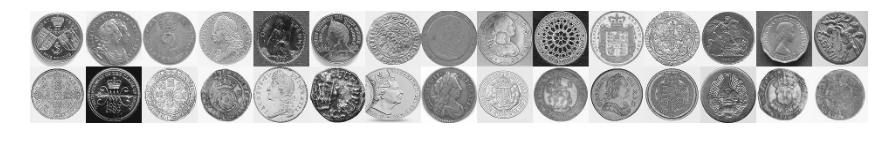

Test images:


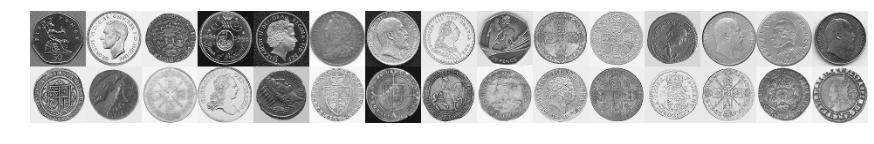

In [4]:
print("Train images:")
show_images(train_images, image_shape, rows=2, cols=15)
print("Test images:")
show_images(test_images, image_shape, rows=2, cols=15)

## TF Neural Networks

In [263]:
def conv2d_maxpool(inputs, filters, kernel_size=[3,3], padding="same", activation=tf.nn.relu):
    l = tf.layers.conv2d(
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        padding=padding,
        activation=tf.nn.relu)
    return tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)

def SimilarityNet(image1, image2):
    l = tf.concat([image1, image2], axis=1)
    # l = conv2d_maxpool(l, 16)
    # l = conv2d_maxpool(l, 32)
    # l = conv2d_maxpool(l, 64)
    # l = conv2d_maxpool(l, 128)
    l = tf.contrib.layers.flatten(l)
    
    l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
    l = tf.layers.dense(l, units=2)
    logits = l
    pred   = tf.nn.softmax(logits)
    
    return logits, pred

def sim_loss(true, pred):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=true, logits=pred))

### Embedding Graph

In [264]:
learning_rate = 1e-6
batch_size    = 300

tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    with tf.name_scope('similarity'):
        with tf.device('/gpu:0'):
            image1_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image1')
            image2_pl = tf.placeholder(dtype=tf.float32, shape=[None,]+image_shape, name='image2')
            true_pl   = tf.placeholder(dtype=tf.float32, shape=[None, 2], name='true')
            logits_op, pred_op = SimilarityNet(image1_pl, image2_pl)
            loss_op   = sim_loss(true_pl, logits_op)
            train_op  = tf.train.AdamOptimizer(learning_rate).minimize(loss_op)
            init_op   = tf.global_variables_initializer()

### Batching

In [265]:
def get_next_batch(i, bs):
    img1 = train_images[i:i+bs]
    
    per = np.arange(bs)
    per = np.roll(per, shift=1+np.random.randint(bs-1))
    
    img1 = np.reshape(img1, [-1,]+image_shape)
    img2 = img1[per]
    true = np.zeros([bs,2])
    
    same = np.random.randint(2, size=bs)
    for i in range(bs):
        true[i,same[i]] = 1.
        if same[i]:
            img2[i] = img1[i]
    
    i = i + bs
    if i > len(train_images) - bs:
        i = 0
    
    return i, img1, img2, true

_, im1, im2, t = get_next_batch(0, 8)
for i in range(len(im1)):
    print(t[i,1] == np.all(im1[i]==im2[i]), np.all(im1[i]==im2[i]), t[i])


True False [ 1.  0.]
True False [ 1.  0.]
True True [ 0.  1.]
True False [ 1.  0.]
True False [ 1.  0.]
True False [ 1.  0.]
True True [ 0.  1.]
True False [ 1.  0.]


### Train embedding

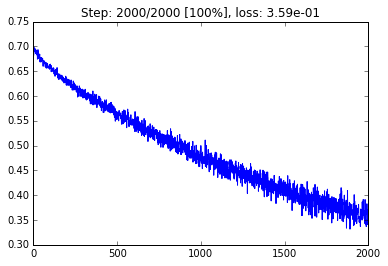

CPU times: user 1min 34s, sys: 54 s, total: 2min 28s
Wall time: 1min 22s


In [266]:
%%time

try:
    sess.close()
except:
    pass
sess = tf.Session(graph=graph)
sess.run(init_op)

def do_train(step_num, log_every=10):
    try:
        losses = []
        i = 0
        for step in range(step_num):
            i, img1, img2, true = get_next_batch(i, batch_size)
            _, loss = sess.run([train_op, loss_op], feed_dict={
                image1_pl: img1,
                image2_pl: img2,
                true_pl  : true
            })
            losses.append(loss)
            if step % log_every == log_every-1:
                show_losses(losses, step, step_num)
    except KeyboardInterrupt:
        pass
    show_losses(losses, step, step_num)
    
do_train(2000, 10)

### Find similar images

[ True  True  True False  True  True  True  True]


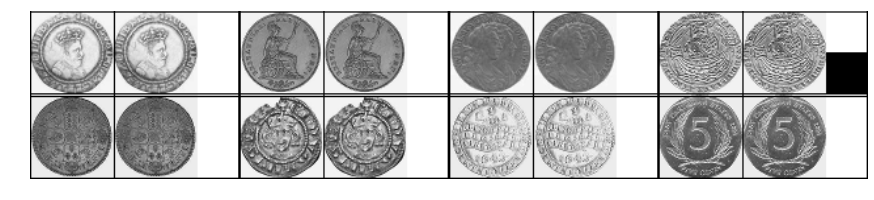

[False False  True False False  True False False]


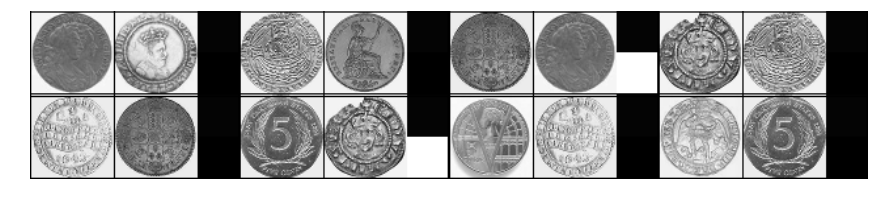

CPU times: user 680 ms, sys: 288 ms, total: 968 ms
Wall time: 662 ms


In [267]:
%%time


def get_similarity(img1, img2):
    img1 = np.reshape(img1, [-1,]+image_shape)
    img2 = np.reshape(img2, [-1,]+image_shape)
    pred = sess.run(pred_op, feed_dict = {
        image1_pl: img1,
        image2_pl: img2
    })
    sim = np.argmax(pred, axis=1)
    return sim == 1.


def test_similarity(images1, images2, num):
    img1 = images1[:num]
    img2 = images2[:num]
    sim = get_similarity(img1, img2)

    print(sim)
    h  = image_shape[0]
    w  = image_shape[1]
    w3 = 32
    img1 = img1.reshape([num*h,w])
    img2 = img2.reshape([num*h,w])
    img3 = np.ones([num*h, w3])
    for i in range(num):
        img3[i*h:i*h+h//2]     = np.mean(images1[i] == images2[i])
        img3[i*h+h//2:(i+1)*h] = sim[i]
    
    img1[:,0] = 0
    img3[:,w3-1] = 0
    sheet = np.concatenate([img1, img2, img3], axis=1)
    sheet[np.arange(0,h*num,h)-1,:] = 0
    sheet[np.arange(0,h*num,h)+1,:] = 0
    cols = 4
    show_images(images=sheet, image_shape=[h, 2*w+w3], cols=cols, rows=num//cols)
        
test_similarity(
    images1  = test_images[100:], 
    images2  = test_images[100:], 
    num      = 8)
test_similarity(
    images1  = test_images[102:], 
    images2  = test_images[100:], 
    num      = 8)

### EOF